In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
words = open('../../names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:]) 

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [6]:
max_steps = 1
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  probs = F.softmax(logits, dim=1)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/      1: 3.3239


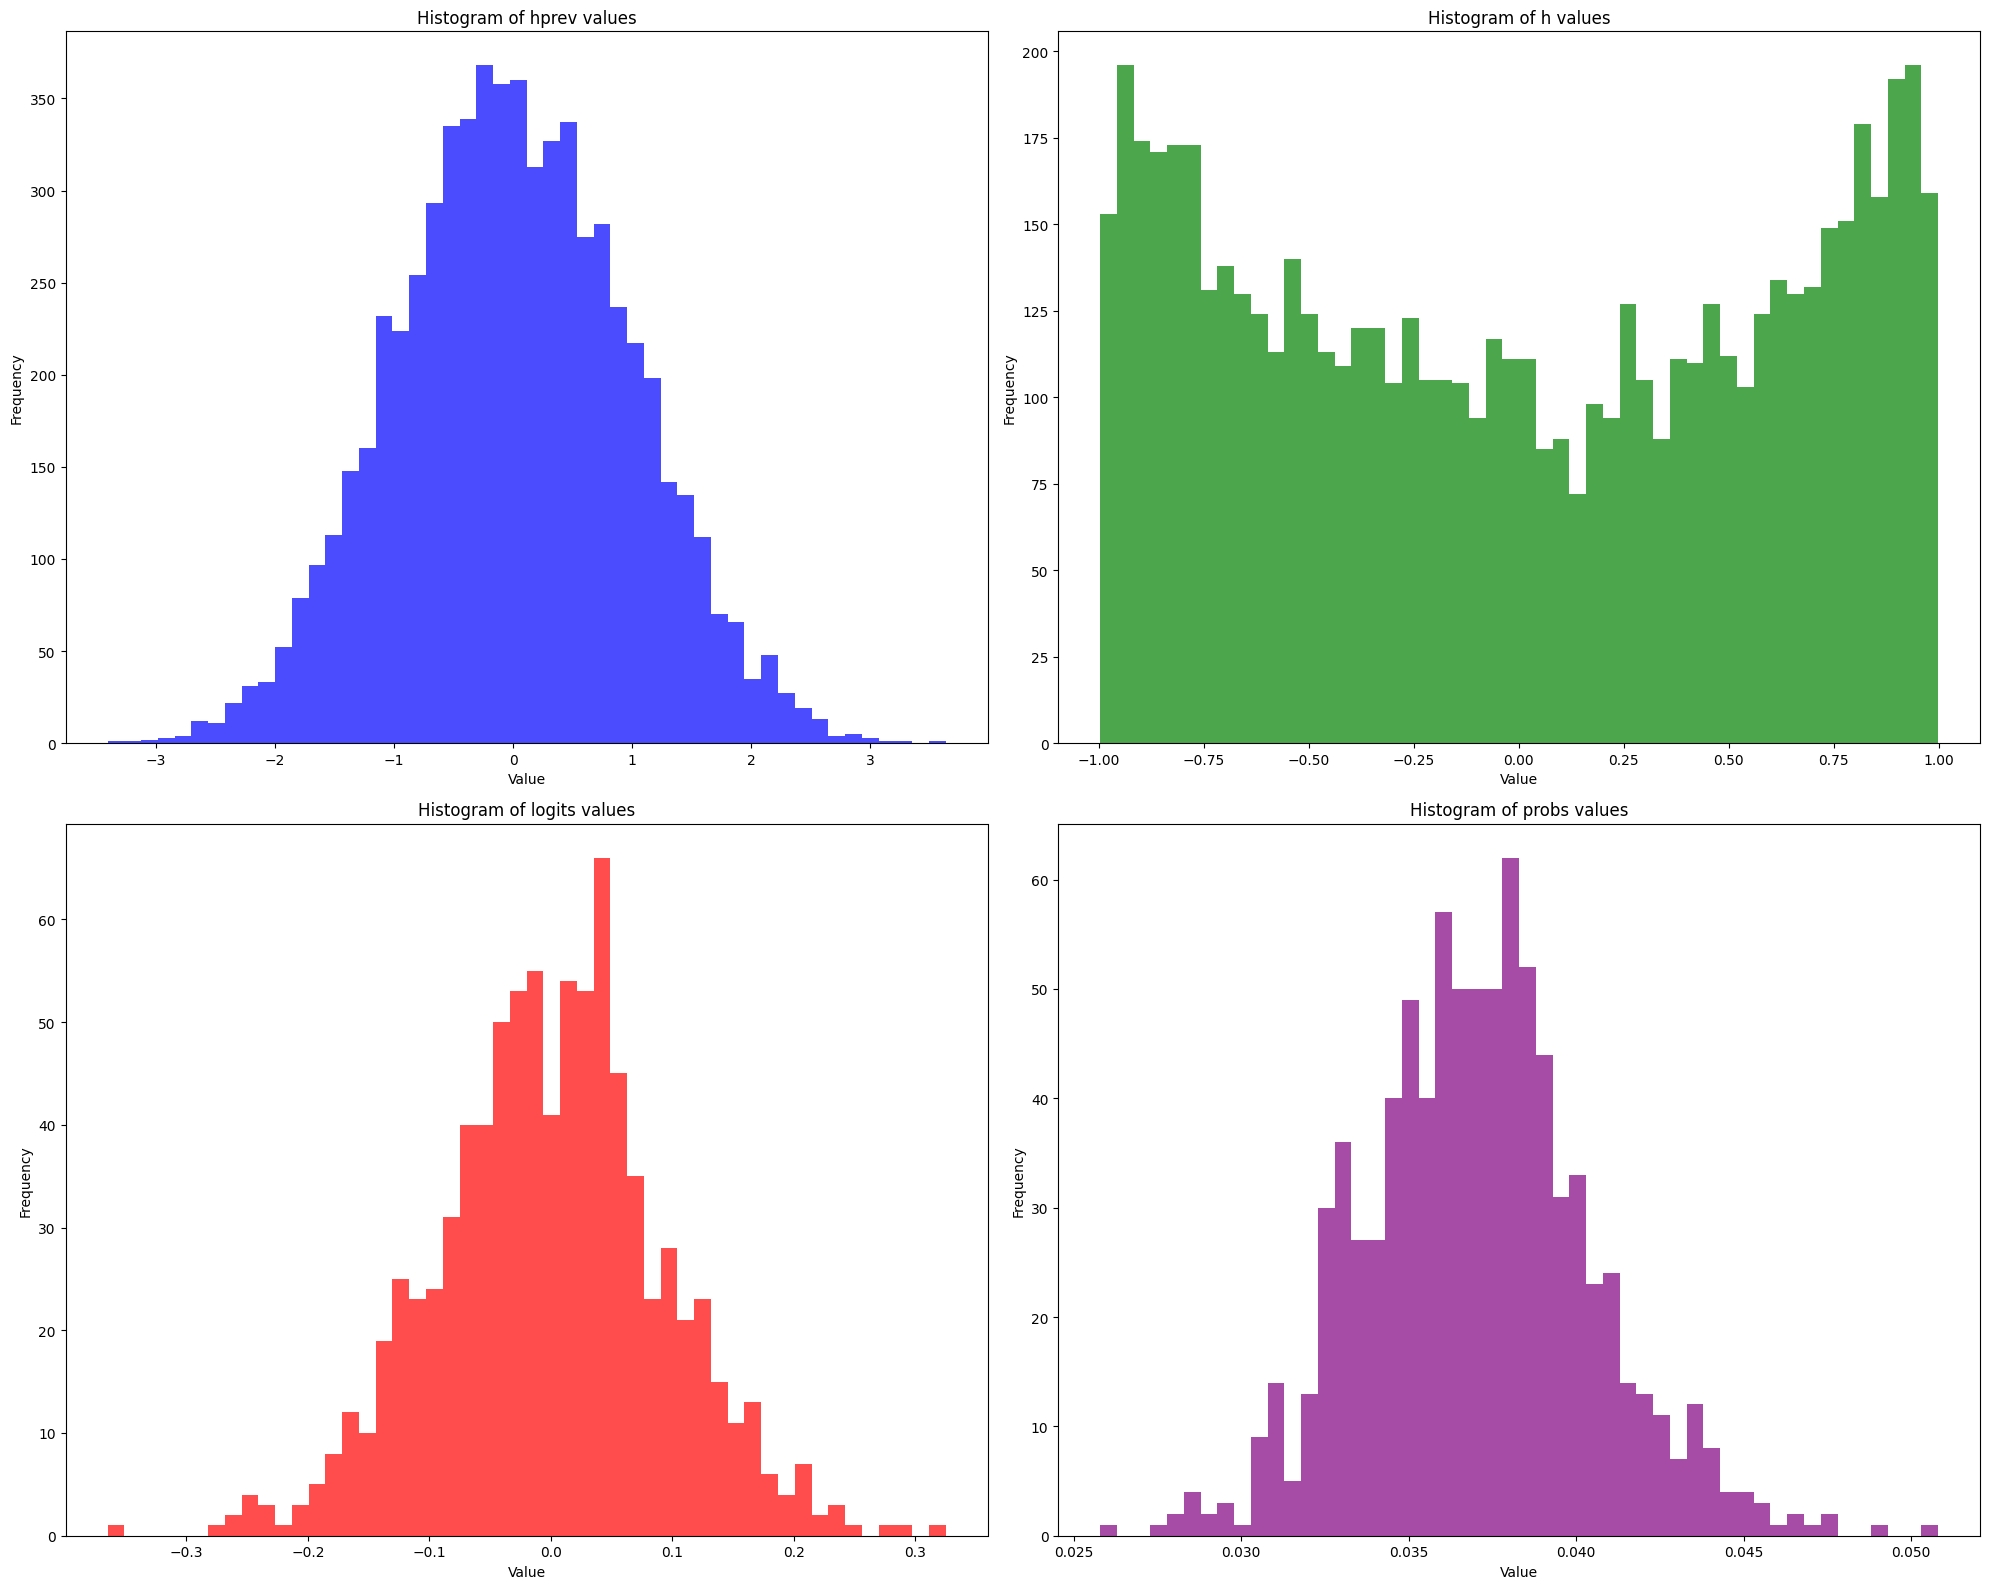

In [7]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Your code to get hprev, h, logits, and probs
# ...

# Convert the tensors to NumPy and flatten them for histogram plotting
hprev_numpy = hpreact.detach().numpy().flatten()
h_numpy = h.detach().numpy().flatten()
logits_numpy = logits.detach().numpy().flatten()
probs_numpy = probs.detach().numpy().flatten()

# Create a figure with 2x2 grid of axes
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# Plot histogram for hprev
axs[0, 0].hist(hprev_numpy, bins=50, color='blue', alpha=0.7)
axs[0, 0].set_title('Histogram of hprev values')
axs[0, 0].set_xlabel('Value')
axs[0, 0].set_ylabel('Frequency')

# Plot histogram for h
axs[0, 1].hist(h_numpy, bins=50, color='green', alpha=0.7)
axs[0, 1].set_title('Histogram of h values')
axs[0, 1].set_xlabel('Value')
axs[0, 1].set_ylabel('Frequency')

# Plot histogram for logits
axs[1, 0].hist(logits_numpy, bins=50, color='red', alpha=0.7)
axs[1, 0].set_title('Histogram of logits values')
axs[1, 0].set_xlabel('Value')
axs[1, 0].set_ylabel('Frequency')

# Plot histogram for probs
axs[1, 1].hist(probs_numpy, bins=50, color='purple', alpha=0.7)
axs[1, 1].set_title('Histogram of probs values')
axs[1, 1].set_xlabel('Value')
axs[1, 1].set_ylabel('Frequency')

# Layout adjustment and display
plt.tight_layout()
plt.show()


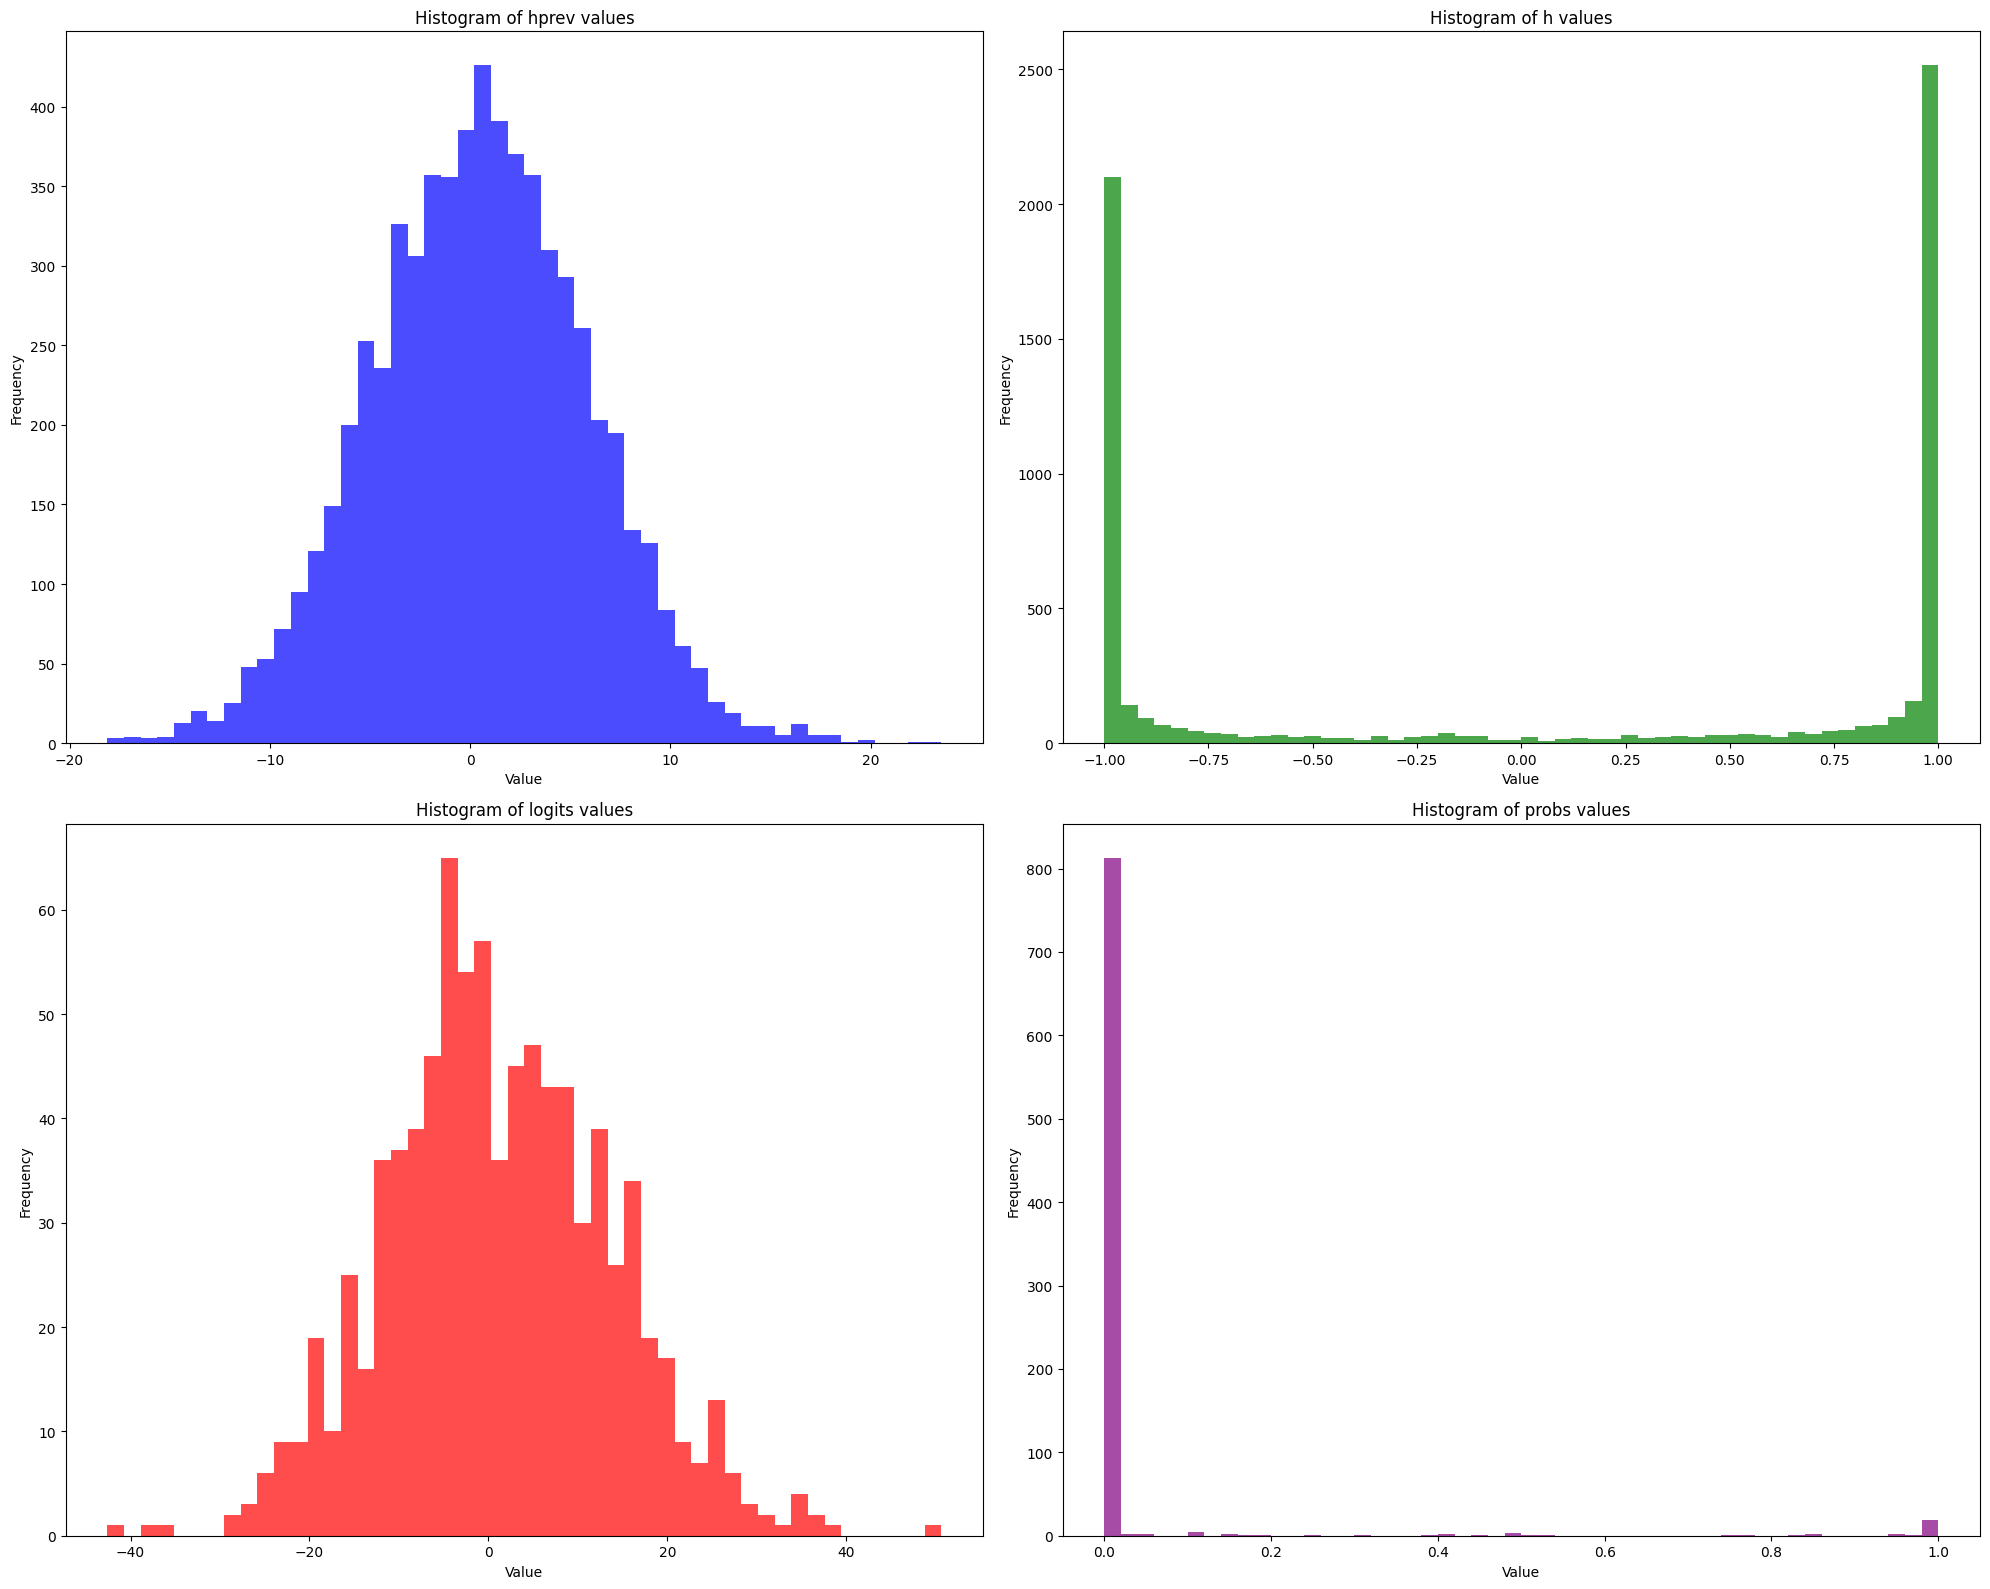

In [85]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Your code to get hprev, h, logits, and probs
# ...

# Convert the tensors to NumPy and flatten them for histogram plotting
hprev_numpy = hprev.detach().numpy().flatten()
h_numpy = h.detach().numpy().flatten()
logits_numpy = logits.detach().numpy().flatten()
probs_numpy = probs.detach().numpy().flatten()

# Create a figure with 2x2 grid of axes
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# Plot histogram for hprev
axs[0, 0].hist(hprev_numpy, bins=50, color='blue', alpha=0.7)
axs[0, 0].set_title('Histogram of hprev values')
axs[0, 0].set_xlabel('Value')
axs[0, 0].set_ylabel('Frequency')

# Plot histogram for h
axs[0, 1].hist(h_numpy, bins=50, color='green', alpha=0.7)
axs[0, 1].set_title('Histogram of h values')
axs[0, 1].set_xlabel('Value')
axs[0, 1].set_ylabel('Frequency')

# Plot histogram for logits
axs[1, 0].hist(logits_numpy, bins=50, color='red', alpha=0.7)
axs[1, 0].set_title('Histogram of logits values')
axs[1, 0].set_xlabel('Value')
axs[1, 0].set_ylabel('Frequency')

# Plot histogram for probs
axs[1, 1].hist(probs_numpy, bins=50, color='purple', alpha=0.7)
axs[1, 1].set_title('Histogram of probs values')
axs[1, 1].set_xlabel('Value')
axs[1, 1].set_ylabel('Frequency')

# Layout adjustment and display
plt.tight_layout()
plt.show()


In [ ]:
[(max(data).item(),min(data).item()) for data in hprev],len([(max(data),min(data)) for data in hprev]), hprev.size()


In [ ]:
[(max(data).item(),min(data).item()) for data in h],len([(max(data),min(data)) for data in h]), h.size()
